# Investigating and Modeling Telco Churn

In [1]:
#Importing Functions and Libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('nipy_spectral')
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pydataset as data

#Importing pre-written scripts to streamline data acquisition and cleaning:
from acquire import get_telco_data
from prepare import clean_telco_data, prep_telco_data, telco_sample_splitter
from env import get_db_url

#Defining an overall alpha for statistical tests:
α = .05

# What's the Plan?

- ReadMe can be found [here](https://github.com/greg-maggard/telco_classification_project/blob/main/README.md), containing a data dictionary, project goals, and some initial hypotheses about drivers of customer churn. 
- Acquire data via pre-written scripts to pull from Codeup's database.
- Prepare data via pre-written scripts for EDA and modeling.
- Establish at least two hypotheses and their corresponding null hypotheses, run tests to determine whether we can reject those nulls. Document findings for reference.
- Establish and document a baseline accuracy to which we can compare our eventual models.
- Train classification models.
- Evaluate models on train and test samples. 
- Evaluate best model on test sample.
- Create CSV file containing customer ID, our model's prediction of whether they will churn, and the expected probability that will be the case. 
- Document conclusions, key insights, and recommendations.

# The Gregxecutive Summary:

- Of the 4 types of models I ran (Decision Tree, Random Forest, K Nearest Neighbors, and Logistic Regression), the Random Forest performed best, with an ultimate test accuracy of ~ 82%.
- This model outperforms the baseline prediction by ~ 9%.
- Given more time in the future, I would like to run some multivariate analysis to control for certain features in order to determine which relationships are truly causal in nature. 

# Acquiring and Preparing the Data:

In [2]:
# Acquiring Data:
telco_df = get_telco_data()

#Splitting Data in to Train, Validate, and Test Sets:
train, validate, test = prep_telco_data(telco_df)
#Showing the first few rows to check that data saved properly:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_Fiber optic,internet_service_type_None
3270,4673-KKSLS,Female,No,No,No,31,Yes,No,Yes,No,...,0,0,0,0,0,0,1,0,1,0
6084,8623-ULFNQ,Female,Yes,No,No,26,Yes,Yes,No,No,...,0,1,1,0,0,0,1,0,0,0
4470,6303-KFWSL,Female,No,No,No,29,Yes,Yes,No,Yes,...,0,0,1,1,0,0,1,0,0,0
428,0623-IIHUG,Female,Yes,No,No,21,No,No phone service,Yes,No,...,0,0,1,0,0,0,1,0,0,0
3329,4742-DRORA,Male,No,Yes,Yes,60,Yes,Yes,Yes,No,...,0,0,1,1,0,0,0,0,1,0


In [3]:
X_train, y_train, X_validate, y_validate, X_test, y_test = telco_sample_splitter(train, validate, test)

## Acquire & Prepare Takeaways: 

- There were 11 nulls to be removed (these customers have not completed a full billing cycle)
- I dropped some unnecessary columns. 
- Split into train, validate, and test, stratifying on churn column.
## Add link to acquire and prepare files.

# Exploration:

### What Proportion of Customers Churned Last Month?

<AxesSubplot:title={'center':'How Many Customers Churned?'}, xlabel='churn', ylabel='Count'>

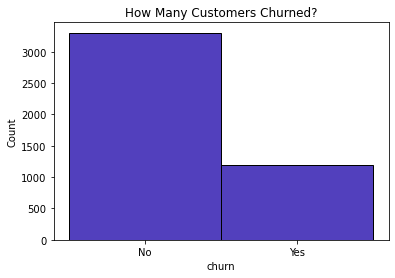

In [4]:
plt.title("How Many Customers Churned?")
sns.histplot(train, x = 'churn', legend = True)

In [5]:
(train[train.churn == 'Yes'].count().churn / train.churn.shape[0]) * 100

26.57777777777778

- Around 26.6% of customer churned this month.

### What Is the Relationship Between Payment Method and Churn?

[Text(0.5, 1.0, 'Are Customers Who Pay With Electronic Check More Likely to Churn? (Spoiler: Yes!)')]

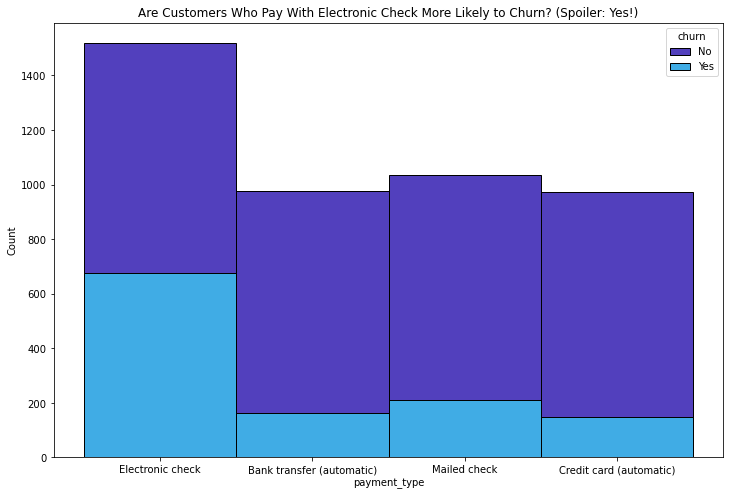

In [6]:
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(1,1,1)

sns.histplot(data= train, ax=ax, stat="count", multiple="stack",
             x="payment_type", kde=False, hue="churn",
             element="bars", legend=True).set(Title = "Are Customers Who Pay With Electronic Check More Likely to Churn? (Spoiler: Yes!)")

#### Statistical Testing
- $H_0$: Customers paying with e-check are equally or less likely to churn.
- $H_a$: Customers paying with e-check are more likely to churn.

In [7]:
e_check_hypothesis = train[['payment_type', 'churn']]
e_check_hypothesis['e_check_boolean'] = (train['payment_type'] == 'Electronic check')
#e_check_hypothesis

e_check_contingency_table = pd.crosstab(e_check_hypothesis.churn, e_check_hypothesis.e_check_boolean)

chi2, p, degf, expected = stats.chi2_contingency(e_check_contingency_table)

p < α

True

##### Conclusion:
- We can reject the null that customers paying with e-check are equally or less likely to churn. 

##### Takeaway:
- Customers paying with e-check are more likely to churn.

### What Is the Relationship Between Multiple Lines and Churn?

[Text(0.5, 1.0, 'Are Customers With Multiple Lines Less Likely to Churn? (Spoiler: No!)')]

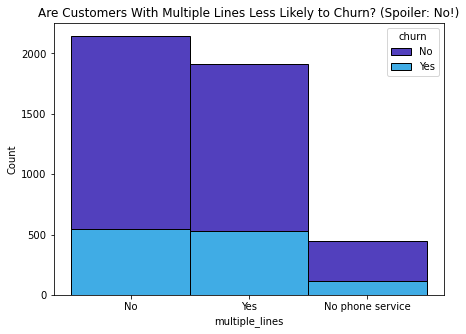

In [8]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

sns.histplot(data= train, ax=ax, stat="count", multiple="stack",
             x="multiple_lines", kde=False, hue="churn",
             element="bars", legend=True).set(Title = "Are Customers With Multiple Lines Less Likely to Churn? (Spoiler: No!)")

#### Statistical Testing
- $H_0$: Customers with multiple lines are equally or less likely to churn.
- $H_a$: Customers with multiple lines are more likely to churn.

In [9]:
multiple_line_hypothesis = train[['multiple_lines', 'churn']]
multiple_line_hypothesis['multiple_lines_boolean'] = (train['multiple_lines'] == 'Yes')
#multiple_line_hypothesis

multi_line_contingency_table = pd.crosstab(multiple_line_hypothesis.churn, multiple_line_hypothesis.multiple_lines_boolean)

chi2, p, degf, expected = stats.chi2_contingency(multi_line_contingency_table)

p < α

False

##### Conclusion:
- We cannot reject the null that customers with multiple lines are equally or less likely to churn. 

##### Takeaway:
- Current evidence does *not* indicate that customers with multiple lines are more likely to churn.

### What is the Relationship Between Internet Service Type and Churn?

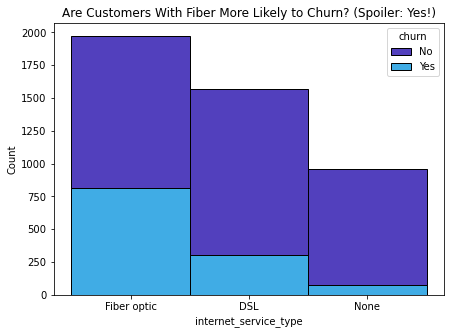

In [10]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

sns.histplot(data= train, ax=ax, stat="count", multiple="stack",
             x="internet_service_type", kde=False, hue="churn",
             element="bars", legend=True).set(Title = "Are Customers With Fiber More Likely to Churn? (Spoiler: Yes!)")
                                              
plt.show()     

#### Statistical Testing
- $H_0$: Customers with fiber optic internet are equally or less likely to churn.
- $H_a$: Customers with fiber optic internet are more likely to churn.

In [11]:
fiber_optic_hypothesis = train[['internet_service_type', 'churn']]
fiber_optic_hypothesis['fiber_optic'] = (train['internet_service_type'] == 'Fiber optic')
#fiber_optic_hypothesis

contingency_table = pd.crosstab(fiber_optic_hypothesis.churn, fiber_optic_hypothesis.fiber_optic)

chi2, p, degf, expected = stats.chi2_contingency(contingency_table)

p < α

True

##### Conclusion:
- We can reject the null that customers with fiber optic internet are equally or less likely to churn. 

##### Takeaway:
- Customers with fiber optic internet are more likely to churn.

### Exploration, Recapped:
- 26.6% of customers churned in the last month
- Customers who payed with electronic checks are more likely to churn
- Fiber optic customers are more likely to churn
- Customers having a multiple lines does not appear to be a predictor of churn
- I'm keeping all of the parameters for modeling, as removing multiple_lines made no appreciable difference in model performance

# Using the Best 3 Models:

## Baseline: 

### The Baseline Model Predicts Customers Will *Not* Churn and Its Accuracy is ~73.4%

In [12]:
# Calculating Baseline Accuracy:
baseline_accuracy = (train[train['churn'] == 'No'].shape[0] / train.shape[0]) * 100
baseline_accuracy

73.42222222222222

## Decision Tree:
- max_depth = 4

In [13]:
#Creating the object and fitting the model:
tree = DecisionTreeClassifier(max_depth=4, random_state=123)
tree = tree.fit(X_train, y_train)

### In-Sample Accuracy is ~ 78.3%

In [14]:
#Performance on In-Sample Data:
dt_in_sample_accuracy = tree.score(X_train, y_train)
dt_in_sample_accuracy

0.7828888888888889

### Out-of-Sample Accuracy is ~ 80.5%

In [15]:
#Performance on Out-of-Sample Data:
dt_out_of_sample_accuracy = tree.score(X_validate, y_validate)
dt_out_of_sample_accuracy

0.8053333333333333

## Random Forest:
- min_samples_per_leaf = 10
- max_depth = 10

In [16]:
#Creating the object and fitting the model:
rf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 10, random_state = 123)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, random_state=123)

### In-Sample Accuracy is ~ 81.4%

In [17]:
#Performance on In-Sample Data:
rf_in_sample_accuracy = rf.score(X_train, y_train)
rf_in_sample_accuracy

0.8135555555555556

### Out-of-Sample Accuracy is ~ 81.5%

In [18]:
#Performance on Out-of-Sample Data:
rf_out_of_sample_accuracy = rf.score(X_validate, y_validate)
rf_out_of_sample_accuracy

0.8151111111111111

## K-Nearest Neighbors (KNN):
- k = 18

In [19]:
#Creating the model object and fitting the data:
knn = KNeighborsClassifier(n_neighbors=18, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=18)

### In-Sample Accuracy is ~ 80.1%

In [20]:
#Performance on In-Sample Data:
knn_in_sample_accuracy = knn.score(X_train, y_train)
knn_in_sample_accuracy

0.8008888888888889

### Out-of-Sample Accuracy is ~ 80.4%

In [21]:
#Performance on Out-of-Sample data:
knn_out_of_sample_accuracy = knn.score(X_validate, y_validate)
knn_out_of_sample_accuracy

0.8035555555555556

# Testing With the Best Model:
- Using overall accuracy as the metric, the Random Forest appeared to be the best model.

## Test Accuracy is ~ 82.0%

In [29]:
#Running the model on the 'test' set to see how we can expect it to perform on future data:
rf_test_sample_accuracy = round(rf.score(X_test, y_test), 2)
rf_test_sample_accuracy

0.82

## Visualizing Model Performance Relative to Differing Hyperparameters:

In [23]:
# Writing a loop to visualize best model's performance in relation to different hyperparameters:
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model (note that as n_samples goes up, max_depth will go down)
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model on the training set to determine accuracy on known data
    forest = forest.fit(X_train, y_train)

    # Evaluate model's performance on training set:
    in_sample_accuracy = forest.score(X_train, y_train)
    
    #Evaluate how the model performs on the validate set to compare with the training set (helps check for overfitting):
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    #creates an entry into a dictionary containing metrics for each hyperparameter combination:
    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)

# converting output dictionary to dataframe:    
df = pd.DataFrame(metrics)
#Adding a 'difference' column that contains values for the difference between the model's accuracy on the train and validate sets:
df["difference"] = df.train_accuracy - df.validate_accuracy

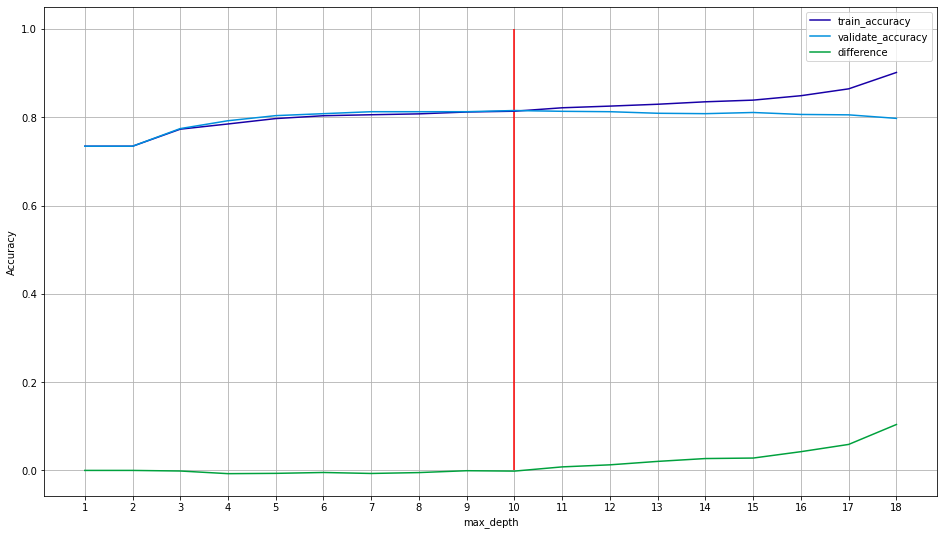

In [24]:
#Creating a graph to chart the metrics for each of the above hyperparameter combinations:
df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

#Adding a red line to show the most optimal hyperparameter combination for this Random Forest Model:
plt.vlines(x = 10, ymin = 0, ymax = 1, colors = 'r', linestyles = 'solid')

#### Takeaway:
- I wanted to select a model that has the best accuracty possible, but doesn't have a massive difference in accuracy between train and validate. High accuracy but with a big difference in train/validate performance indicates overfitting.
### "Optimize for accuracy, ensure model generalizes."

# In Summary:


## Takeaways
- Payment type and fiber optic internet are good predictors of churn, while having multiple lines is not. 
- Using the random forest model, I was able to achieve an ~82% accuracy in predicting whether a customer would churn, which beats the baseline model by ~ 8.6%.
- This model does well on unseen data (tested on two unseen datasets).
- I would expect this model to reasonably perform with about 80% accuracy on future data.

## Recommendations:
- Advocating for customers to sign up for a payment method other than electronic check.
- Figure out what's happening with fiber optic internet.

## Next Steps:
- Run some more multivariate analysis to understand which features have legitimate causal relationships with churn. Understanding this better may help improve model's performance. 
- Gather data on customer satisfaction, particularly with services like fiber optic internet. This may help understand why having these services seem to indicate a customer will churn.
- I would like to dive into investigating what the issue seems to be with fiber. 

# Sending the predictions to a CSV:

In [25]:
y_predictions = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)

#Creating empty DataFrame:
predictions = pd.DataFrame()
#Creating customer_id column:
predictions['customer_id'] = test.customer_id
#Creating prediction column:
predictions['prediction'] = y_predictions
#Creating probability column:
predictions['probability'] = y_proba[:,1]

predictions.to_csv("predictions.csv")